In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_2359309/1030767214.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [153]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [5]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

In [6]:
adatas, adatas_raw = dp.transfer_htos(adatas, adatas_raw)

In [7]:
# adatas_mad = dp.quality_control(adatas)
adatas_qc = dp.quality_control(adatas)
# adatas_qntl = dp.quality_control(adatas, method = 'qntl')
# adatas_abs = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


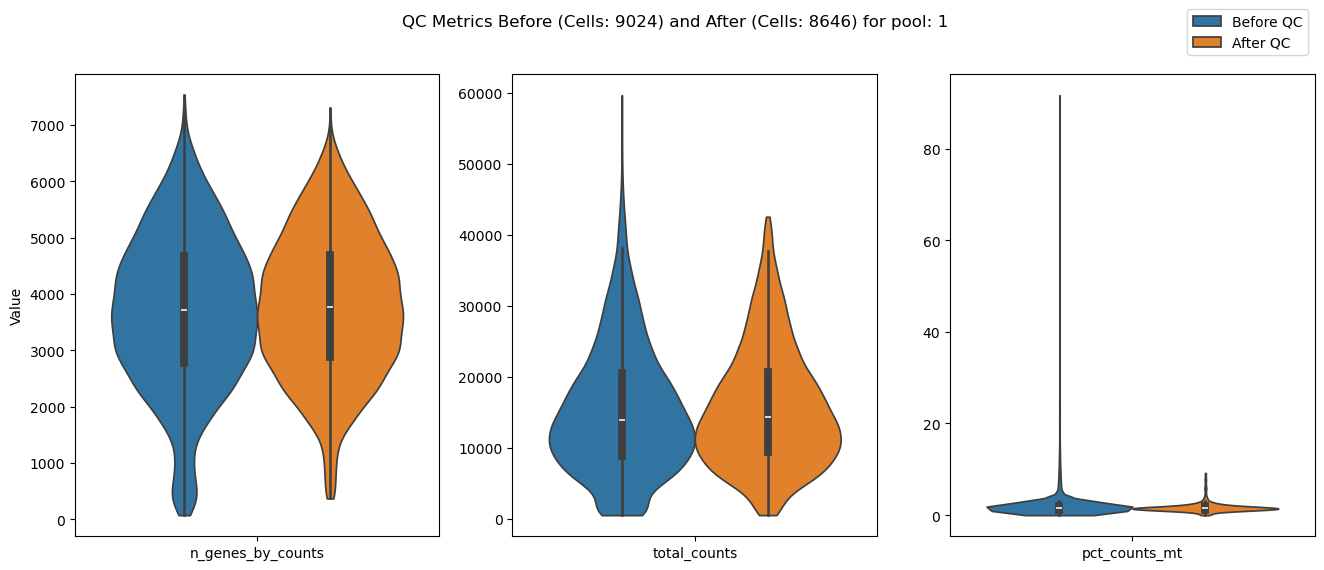

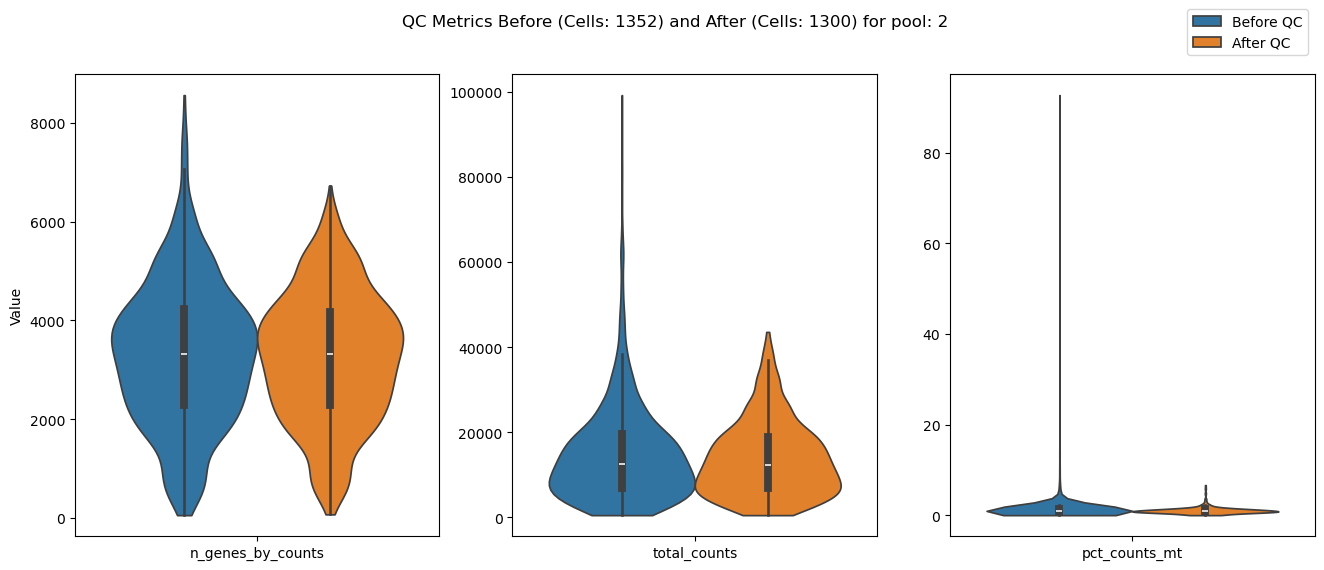

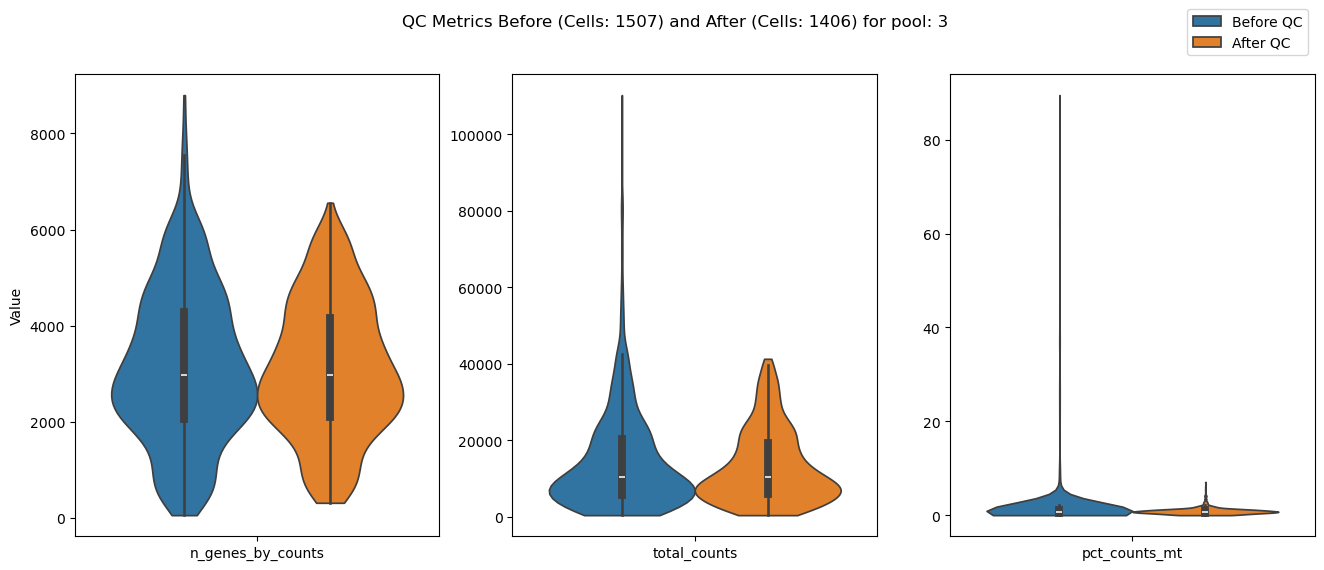

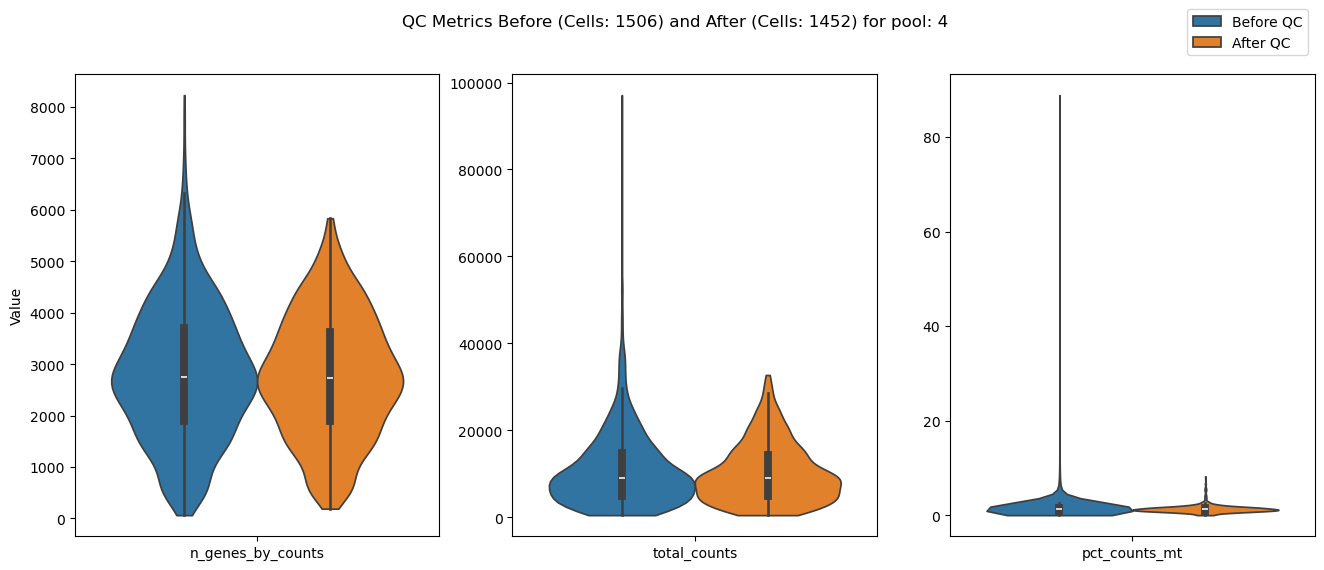

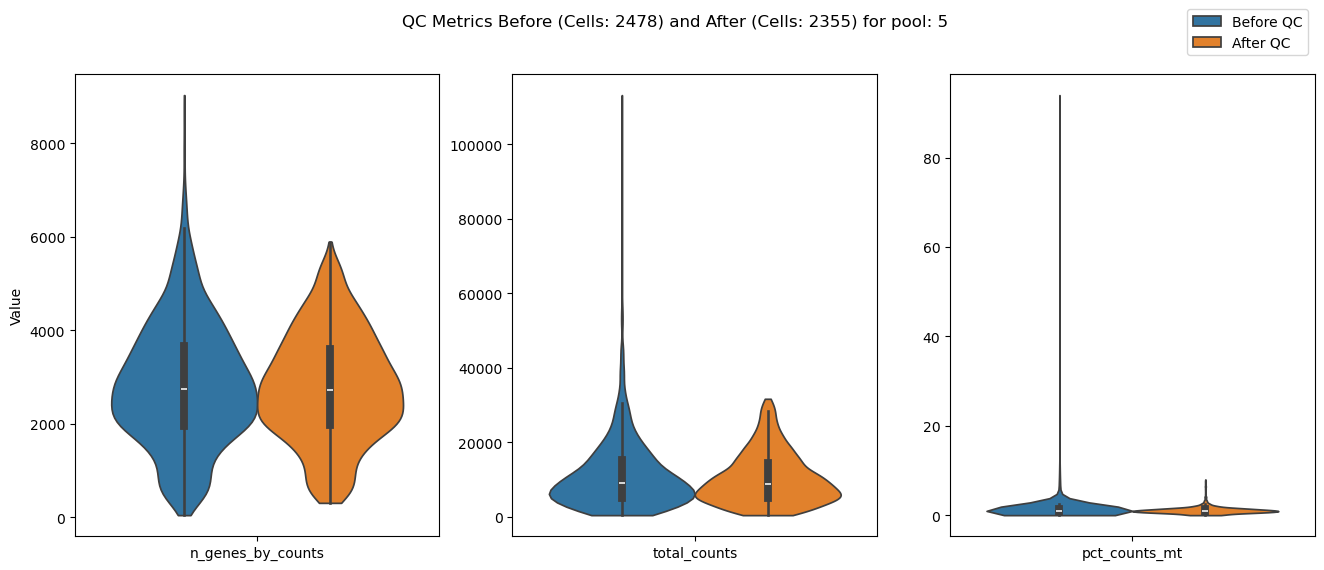

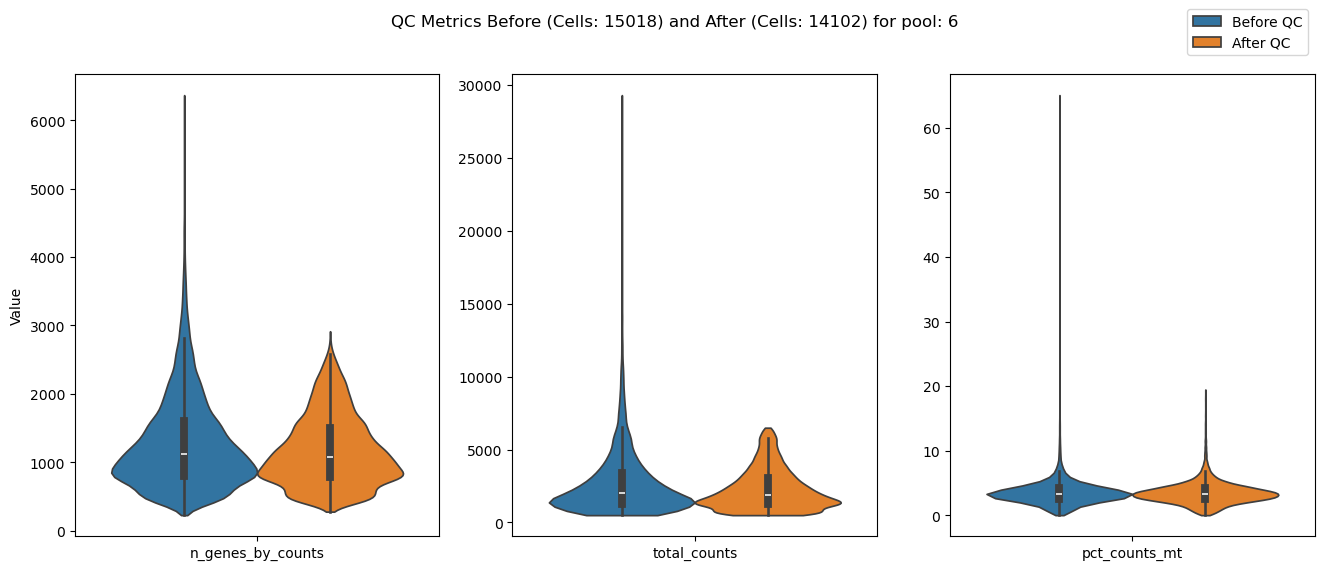

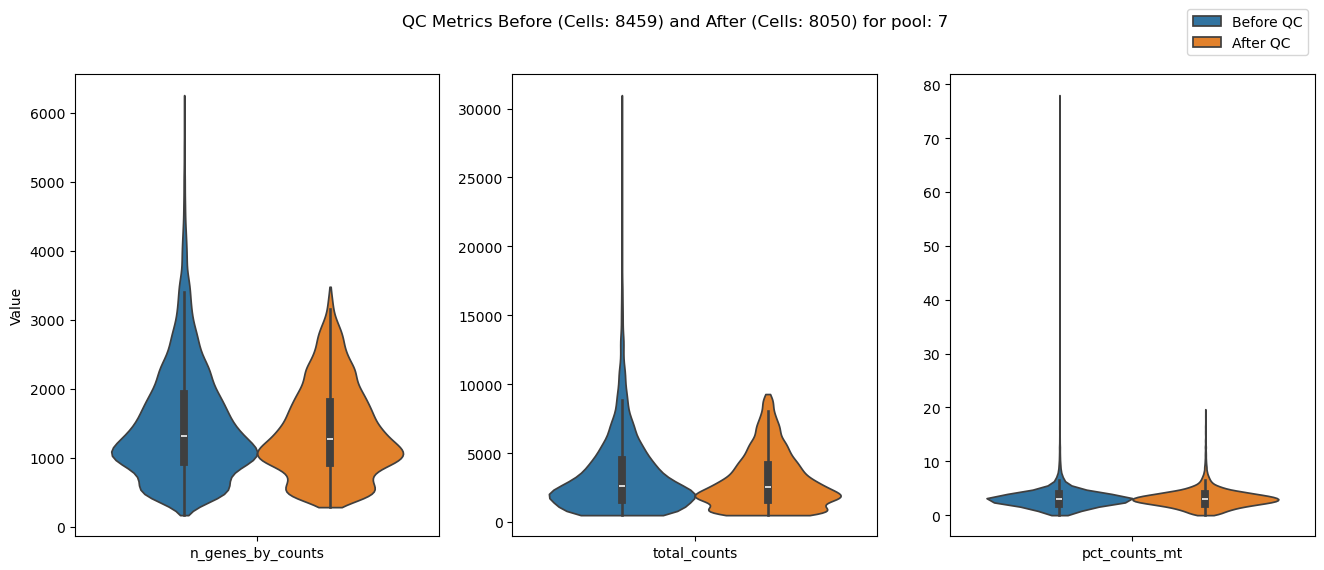

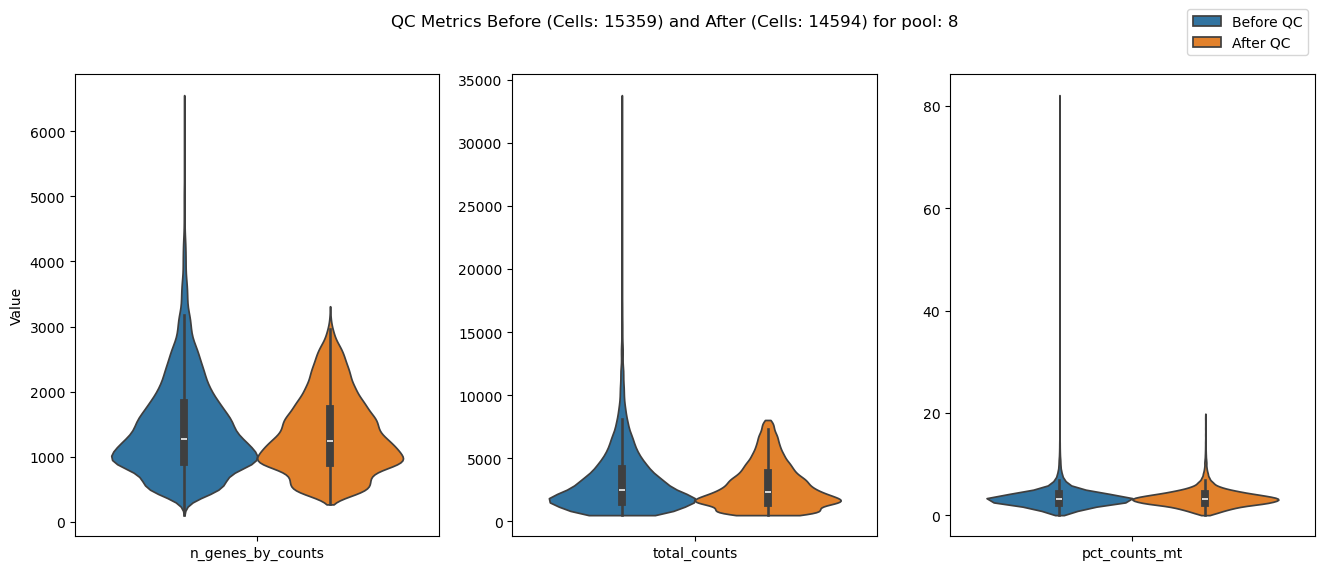

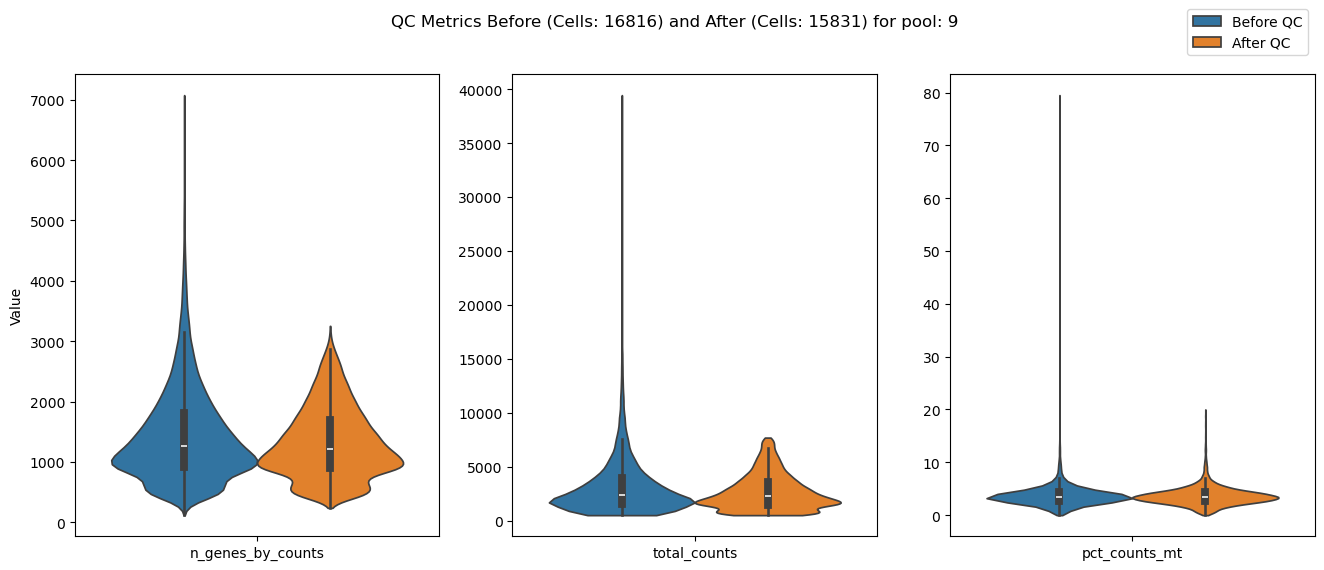

In [8]:
dp.plot_qc_metrics(adatas, adatas_qc)

In [10]:
adatas = adatas_qc

In [200]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [9]:
dp.log1p_and_pregroup(adatas) #for soupX or scran normalization

In [12]:
adata = adatas[0]
adata_raw = adatas_raw[0]

groups = adata.obs['groups']
empty_drops = dp.find_empty_drops(adata_raw)
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T
data_raw = adata_raw.X.T

dp.cook_soup(data, data_raw, genes, cells, groups, empty_drops)

[1] "Data dimensions:"
[1] 33696  8646
[1] "Raw data dimensions:"
[1]  33696 713024
[1] "SoupChannel object created"
[1] "Soup profile set"
[1] "Cluster assignments:"
soupx_groups
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1283  603  286  534  507  700  350  501  781  291  248  276   67  584  730  221 
  16   17 
  96  588 
[1] "Clusters set"
[1] "Contamination fractions estimated:"
[1] 0.021 0.021 0.021 0.021 0.021 0.021


<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 32683463 stored elements and shape (33696, 8646)>